# Taylor-Green Vortex

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Taylor_Green.ipynb)

The Taylor-Green vortex is a special solution to the Navier-Stokes equations whose shape does not change over time. It only decays exponentially.

In [ ]:
%pip install phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange
from functools import partial

The vortex decays exponentially, resulting in small numbers at later times. Therefore, we set the global precision to FP64 (double), which affects all future operations.

In [ ]:
math.set_global_precision(64)  # double precision for all following operations

Let's define our simulation settings.
We use a relatively low viscosity of 0.1, corresponding to a Reynolds number of 1/vis = 10.

In [ ]:
domain = dict(x=25, y=25, boundary=PERIODIC, bounds=Box(x=2*PI, y=2*PI))
viscosity = 0.1

## Closed-Form Solution

The Taylor–Green vortex is an unsteady incompressible flow of a decaying vortex, and has an analytic solution, given below.

In [7]:
def taylor_green_velocity(x, t):
    sin_x, sin_y = math.sin(x).vector
    cos_x, cos_y = math.cos(x).vector
    return vec(x=cos_x*sin_y, y=-sin_x*cos_y) * math.exp(-2 * viscosity * t)

def taylor_green_pressure(x, t):
    return -1 / 4 * (math.sum(math.cos(2 * x), 'vector')) * math.exp(-4 * viscosity * t)

We sample the velocity on a [staggered grid](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html) and the pressure at the cell centers.

In [14]:

time = math.linspace(0, 10., batch(time=200))
analytic_v = StaggeredGrid(partial(taylor_green_velocity, t=time), **domain)
analytic_p = CenteredGrid(partial(taylor_green_pressure, t=time), **domain)

In [11]:
plot({"Velocity": analytic_v.time[::4], "Pressure": analytic_p.time[::4]}, animate='time', same_scale=False)

## Simulation

Let's simulate the vortex with the same settings and initial conditions we used above.

In [21]:
@jit_compile
def step(velocity, pressure, dt):
  velocity = diffuse.explicit(velocity, viscosity, dt)
  velocity = advect.semi_lagrangian(velocity, velocity, dt)
  return fluid.make_incompressible(velocity, (), Solve('CG', 1e-12, 1e-12, x0=pressure))

dt = time.time[1] - time.time[0]
v0, p0 = analytic_v.time[0], analytic_p.time[0]
sim_v, sim_p = iterate(step, time.shape-1, v0, p0, dt=dt)

Now, we can plot the simulation error over time.

<Figure size 864x360 with 2 Axes>

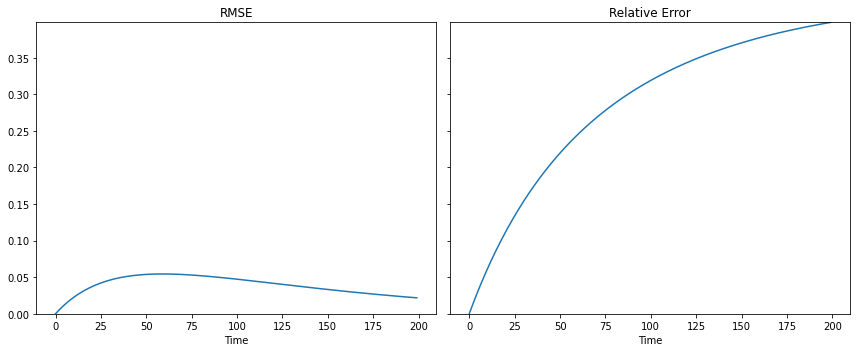

In [32]:
rmse = math.sqrt(math.mean((analytic_v - sim_v).values**2))
relative_err = rmse / math.mean(abs(analytic_v.values))
plot({"RMSE": rmse.time.as_spatial(), "Relative Error": relative_err.time.as_spatial()})